# Data Labeling - Sample names

This notebook contains all the relevant information gathered from other notebooks. Specifically how to reduce the number of sample names and how to assign a sample to a given type (e.g.: trojan, virus, worm).

Name reduction is done in notebook 4.2. The names are composed of several words split by a dot. The filtering is done in each word of the name like such:

- Words are are a single character are removed
- Words that have 2 characters but at least one is a digit are removed
- Words that are hexadecimal are removed

Although simple, these methods reduce the number of names substantially. Specifically, the final number of names is 45% that of the original. Graphics about the number of names per vendor can be seen in notebook 4.0.

With less names, the next task is to have the ability to classify a sample as either trojan, virus or worm (propagation type). This is not trivial, as the name redundancy between vendors is high.

To facilitate the classification step, an undirected graph of malware names was created. The graph had each malware name as a node. An edge between names would exist if the appeared together and had a property with the number of times they appeared together in different samples. An example of the graph for the 10 most frequent names can be seen below.

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

data_folder = '../data/'
vendors_selected_file = data_folder + 'vendors_selected.csv.gz'
name_graph_file = data_folder + 'malware_names_graph.csv.gz'

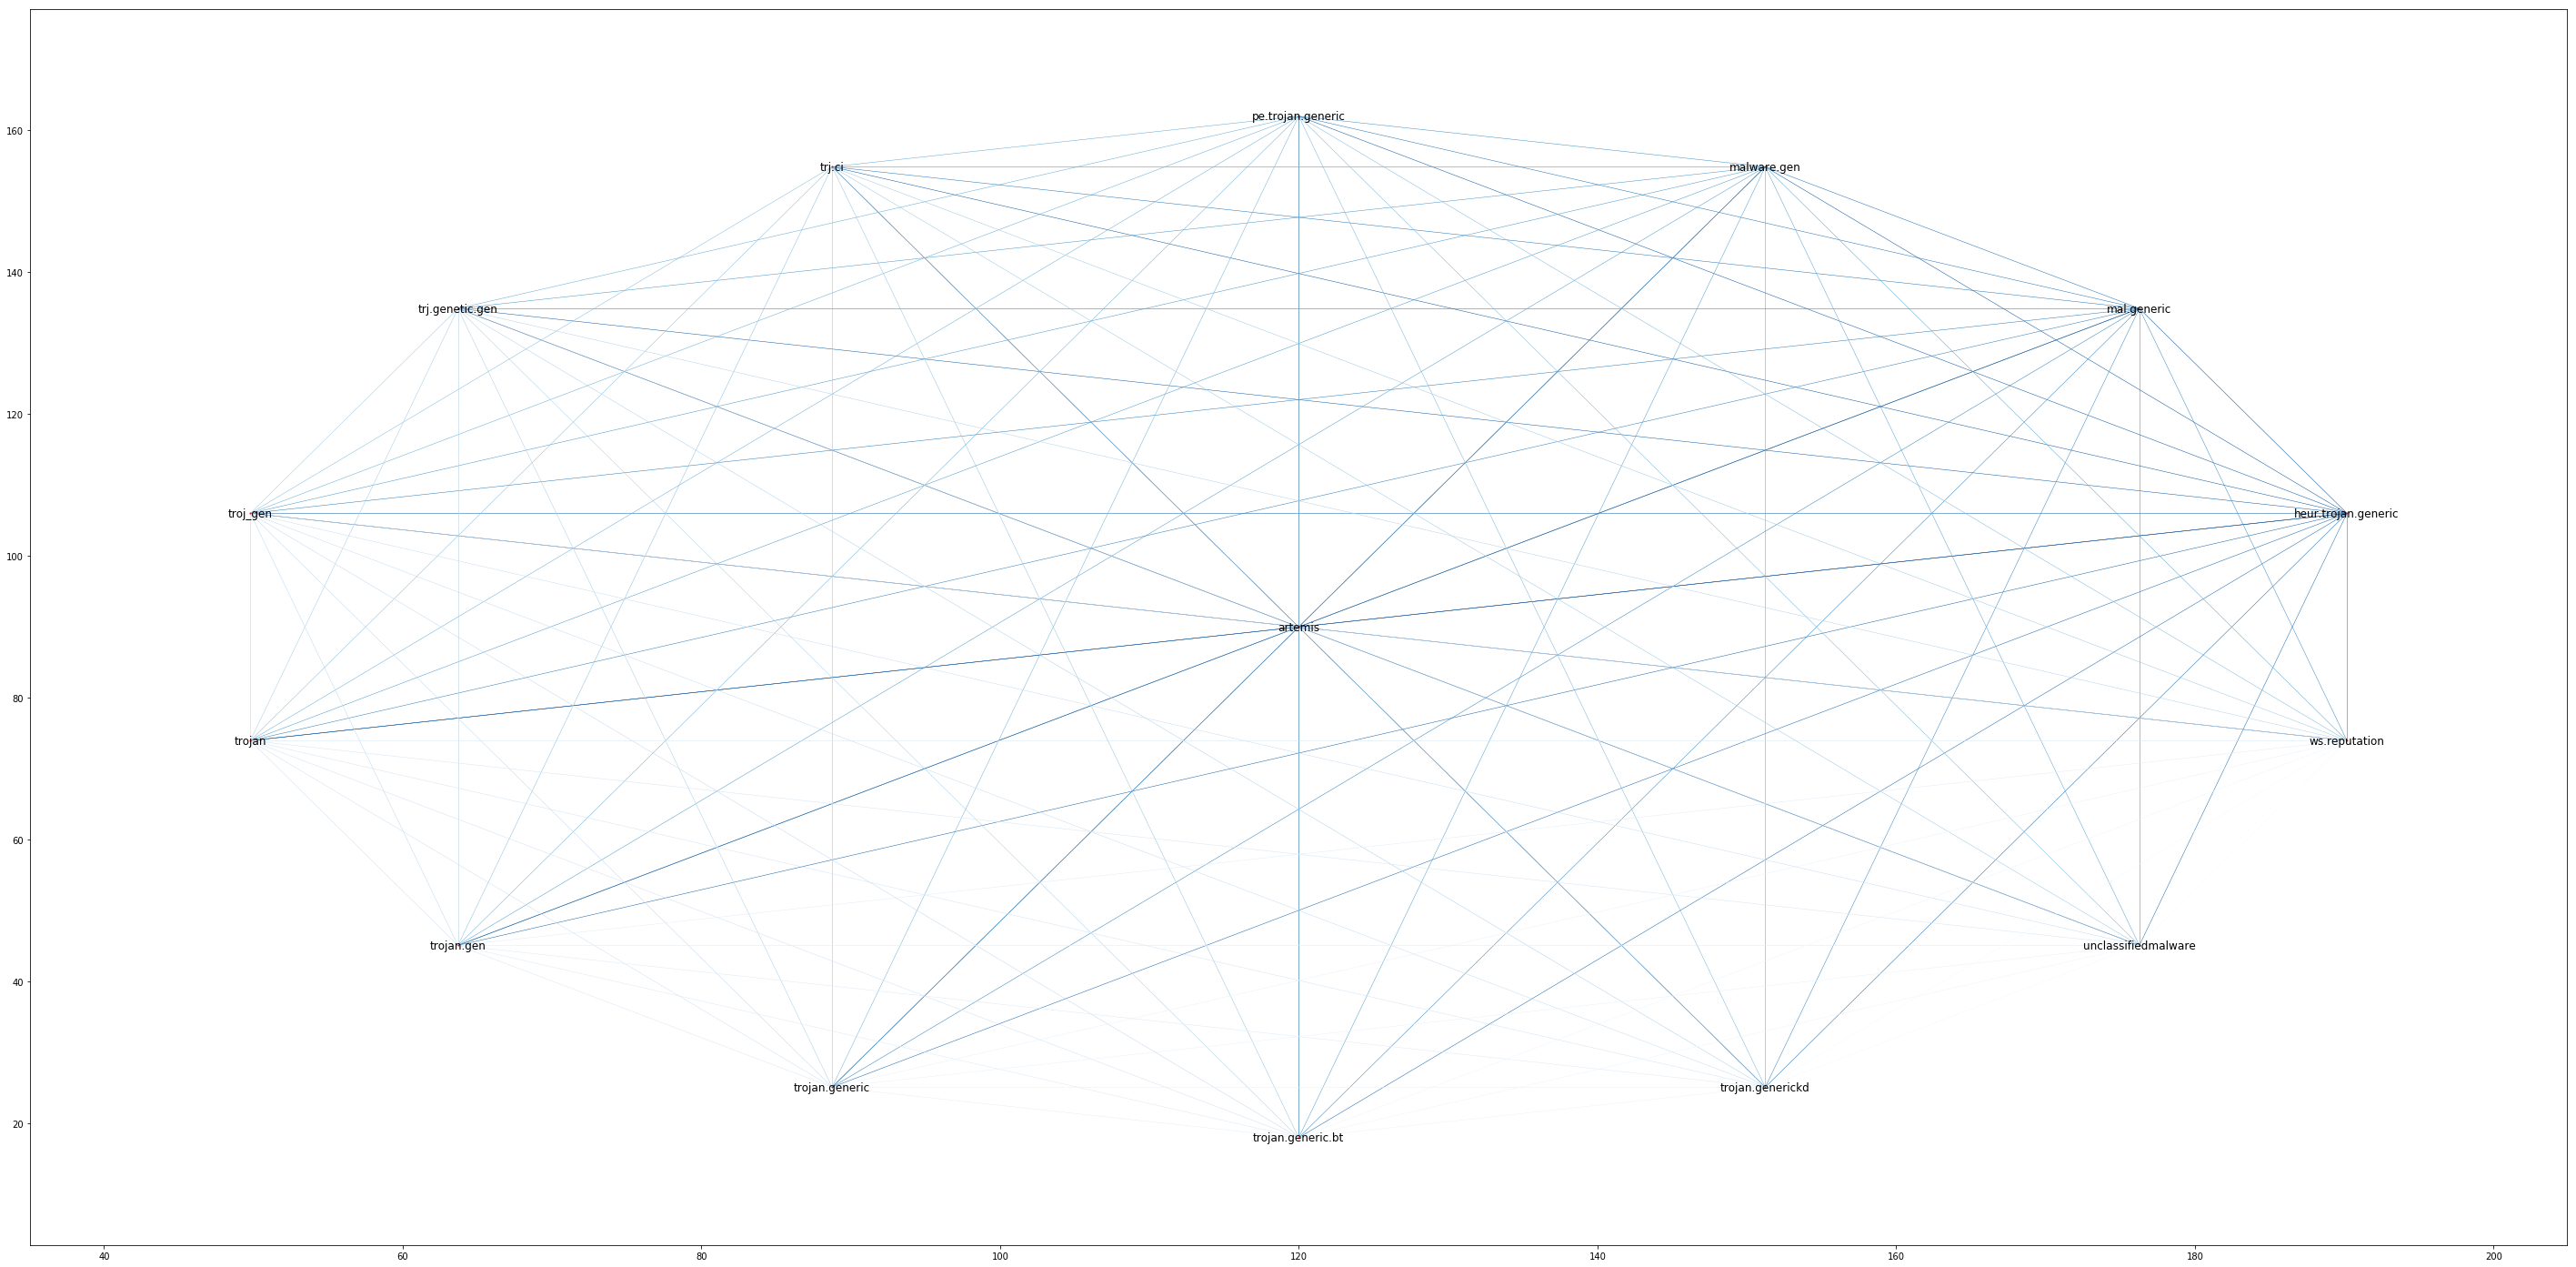

CPU times: user 8.5 s, sys: 1.07 s, total: 9.58 s
Wall time: 9.97 s


In [2]:
%%time
# Notebook 4.2 generates this file, check it for details
frame_graph = pd.read_csv(name_graph_file)
frame_graph = frame_graph[['a', 'b', 'weight']]

# Keep high frequency names as a sample
high_names = set(frame_graph['a'].value_counts().sort_values(ascending=False)[:10].index)
high_names.update(frame_graph['b'].value_counts().sort_values(ascending=False)[:10].index)
frame_graph2 = frame_graph[frame_graph['a'].isin(high_names) & frame_graph['b'].isin(high_names)]

G = nx.from_pandas_dataframe(frame_graph2, 'a', 'b', ['weight'])
colors = range(len(G.edges()))[::-1]
pos = graphviz_layout(G, prog='twopi')

# A4 print size
# plt.figure(figsize=(11.69, 8.27))
plt.figure(figsize=(50, 25))
nx.draw_networkx(G, pos, node_size=1, edge_cmap=plt.cm.Blues, edge_color=colors, width=0.5)
plt.show()
# plt.savefig('test.pdf', format='pdf', dpi=500)
plt.close()

In [22]:
# Top 100 names by ocurrence
name_freq = frame_graph['a'].append(frame_graph['b']).value_counts().sort_values(ascending=False)
display(name_freq[:100])

trojan.generic.bt                       165471
trojan                                  159569
artemis                                 122728
troj_gen                                113063
malware.gen                              98405
mal.generic                              93830
trojan.gen                               90869
unclassifiedmalware                      77439
pe.trojan.generic                        66965
trj.ci                                   63950
trj.genetic.gen                          61799
trojan.generic                           57107
riskware                                 56421
trojan.generickd                         53261
heur.trojan.generic                      46488
ws.reputation                            40925
trojan.agent                             40778
trojan.downloader                        35593
generic.malware                          33292
backdoor                                 27771
gen.variant.kazy                         25380
trojan.horse 

## Neo4j to the rescue

To facilitate the labeling task, Neo4j was used. Neo4j is a graph database, that provides Cypher, a query language making searching and traversing the graph easy.

Given that the task is to be able to classify a sample as trojan, virus or worm, the first step was to find redundant names for trojan, virus and worm. To accomplish this the following algorithm was applied:

- Get all the names connected to $X$
- For each name $M$ connected to $X$ filter first 100 with highest edge weight
- For each name $M$ connected to $X$ count how many other names $A$ are shared by $M$ and $X$ (i.e. common names) and divide the count by the total names connected to $M$
- Return the names $M$ sorted by the obtained ratio

This simple algorithm provides a list of the 100 closest names to $X$. Given that 100 is easily user parsable, manual inspection can be used to filter down the list.

As an example, when applying the algorithm to the name "trojan.generic.bt" (most frequent name for trojan) the following table is obtained:
```
╒══════════════════════════════════════╤══════════════════════╤══════════════════╤══════════╤════════╕
│"m.name"                              │"nm_ratio"            │"common_ratio"    │"w.weight"│"common"│
╞══════════════════════════════════════╪══════════════════════╪══════════════════╪══════════╪════════╡
│"trojan"                              │0.9643260752639435    │0.5866903138473879│46431     │93617   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"artemis"                             │0.7416828326413691    │0.6077228319766637│32896     │74584   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"troj_gen"                            │0.6832738062862979    │0.6494931984221047│32636     │73433   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"malware.gen"                         │0.59469030827154      │0.6713649851632048│18532     │66065   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"mal.generic"                         │0.5670480023689952    │0.704945113503144 │16600     │66145   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.gen"                          │0.5491475847731627    │0.6911013778227759│17012     │62799   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"unclassifiedmalware"                 │0.46799137008901864   │0.7371479487080154│15216     │57084   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"pe.trojan.generic"                   │0.4046932695155042    │0.6183678040767565│7671      │41409   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trj.ci"                              │0.3864725541031359    │0.7152931978107897│10265     │45743   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trj.genetic.gen"                     │0.3734732974358045    │0.5656240392239357│8275      │34955   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.generic"                      │0.34511183228481124   │0.6325955241130529│36032     │36125   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"riskware"                            │0.3409660907349324    │0.6615739099610067│14282     │37326   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.generickd"                    │0.3218690888433623    │0.6964325948178746│40294     │37092   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"heur.trojan.generic"                 │0.28094348858712404   │0.5809456203751506│5984      │27007   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"ws.reputation"                       │0.24732430456092003   │0.6874770922419059│6959      │28135   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.agent"                        │0.24642988801663132   │0.6563749172327538│6406      │26765   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.downloader"                   │0.21509509219138095   │0.577910766464374 │6869      │20569   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"generic.malware"                     │0.20118933226970284   │0.662431287735424 │4019      │22053   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"backdoor"                            │0.16782396915471592   │0.5289881166726683│3921      │14690   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"gen.variant.kazy"                    │0.1533743072804298    │0.6241774695614485│15701     │15841   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.horse"                        │0.147312822186365     │0.6519117164424023│2346      │15891   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"heuristic.lookslike.suspicious"      │0.1414568111632854    │0.5227923270816422│1922      │12237   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.zbot"                         │0.1313160614246605    │0.6107045883381655│3146      │13270   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"troj_spnr"                           │0.12258945676281645   │0.7177717525264974│5425      │14560   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"gen.variant.symmi"                   │0.10879247723165993   │0.5914898344628374│9384      │10648   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"heuristic.behaveslike.suspicious.bay"│0.1081156214684144    │0.5112353269983231│1930      │9146    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"backdoor.trojan"                     │0.10798871101280587   │0.6571156751916727│1794      │11742   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"generic.suspicious"                  │0.10232004399562461   │0.6986002008150729│2039      │11828   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"spyware"                             │0.09941319022668625   │0.6482674772036474│3103      │10664   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"pe.malware.generic.qrs"              │0.09897806866459984   │0.793686652826963 │2573      │12999   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"uds.dangerousobject.multi.generic"   │0.09746118655232638   │0.6779934271718236│2303      │10934   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"downloader"                          │0.09687498111451553   │0.6070492825951341│1595      │9731    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"gen.variant.zusy"                    │0.09402251754083797   │0.7171872991387068│8381      │11158   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.inject"                       │0.09312205764152026   │0.6848594976961516│1848      │10553   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.packed"                       │0.09262650252914408   │0.5351340771188099│1958      │8202    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"unwanted.program"                    │0.0903783744583643    │0.6812437311935807│11465     │10188   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"mal.behav"                           │0.08993720954124892   │0.5843300631635533│1537      │8696    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"gen.variant.graftor"                 │0.08840219736388853   │0.6620180475799836│7177      │9684    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.injector"                     │0.08681883834629633   │0.7460671028818042│2109      │10718   │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"generic.trojan"                      │0.08674027473091962   │0.61889500452867  │1201      │8883    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"suspicious_gen"                      │0.08466136060095122   │0.6310942965236633│1237      │8841    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"suspicious.file"                     │0.08465531724592225   │0.5878783552255854│1129      │8235    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"suspicious.cloud"                    │0.08406911180811139   │0.6957084321759759│1480      │9678    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.crypt"                        │0.07870261254237902   │0.7131229363433924│1729      │9287    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"adware"                              │0.07006061485094064   │0.6126973173466748│2676      │7103    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"suspectcrc"                          │0.06959527651370935   │0.7201285168461271│1780      │8293    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"dropper.gen.drp"                     │0.06806026433634897   │0.727224294086308 │1612      │8190    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.pws.panda"                    │0.06567918245493168   │0.611796098638204 │1220      │6649    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"password.stealer"                    │0.06413812692254232   │0.6551399227362669│1515      │6953    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.suspectcrc"                   │0.0640353898870497    │0.7876557191392979│2226      │8346    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.dynamer.ac"                   │0.06107414592285053   │0.8550366119137146│1688      │8641    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"suspected.of.trojan.downloader.gen"  │0.06095327882227097   │0.6049970255800119│1294      │6102    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trj.gdsda"                           │0.06047585377498172   │0.836714299990007 │1726      │8373    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"pak_generic"                         │0.05884414791715769   │0.6361302249152716│1436      │6194    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"generic.dx"                          │0.0572547455445365    │0.7152206037576525│1744      │6776    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"possiblethreat"                      │0.05570160330208919   │0.7264836714766193│1328      │6696    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"backdoor.bot"                        │0.05230523777580361   │0.6500288850375505│1315      │5626    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"artemis.trojan"                      │0.05104821992977621   │0.8078607789747839│1517      │6824    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trj.chgt"                            │0.0490297393500976    │0.7824479230864045│1089      │6348    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.dropper.agent"                │0.04805675919043216   │0.6394617706237424│1161      │5085    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.adh"                          │0.04803258577031625   │0.7895067941620534│1712      │6275    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"generic"                             │0.043904974285524354  │0.6832759807295251│1596      │4964    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"gen.variant.barys"                   │0.042944080835916866  │0.6640866873065016│3257      │4719    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.encoder"                      │0.042750693474989575  │0.7480916030534351│1074      │5292    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"rootkit.gen.rtk"                     │0.042291398492787256  │0.7276364675621606│1442      │5092    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.generic.kdv"                  │0.04164475950468662   │0.6968509650268466│2368      │4802    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"backdoor.generic"                    │0.039583975439805165  │0.702442748091603 │2423      │4601    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"rdn.generic.dx"                      │0.039312024463501155  │0.8594926979246733│1793      │5591    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"hacktool"                            │0.036308477014099144  │0.7871171770972037│2053      │4729    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"gen.variant.strictor"                │0.03351040363568238   │0.7192064923354373│3106      │3988    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.generickdv"                   │0.031987478168379956  │0.6640846400906858│2491      │3515    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"worm.generic"                        │0.03127436227496057   │0.6110144927536232│4053      │3162    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"heuristic.behaveslike.suspicious"    │0.025067836660200276  │0.6000482160077145│2524      │2489    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"adware.downware"                     │0.024596454967940003  │0.6316953316953317│2043      │2571    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.generickdz"                   │0.024010249530129146  │0.6425874653913919│1403      │2553    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"gen.variant.razy"                    │0.020758924524539042  │0.7790393013100436│1884      │2676    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"troj_ge"                             │0.020644100778988463  │0.859192037470726 │1272      │2935    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"application.generic"                 │0.01647418580899372   │0.7413793103448276│1380      │2021    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.muldrop4"                     │0.016292885158124385  │0.6984421364985163│2391      │1883    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"worm.autoit"                         │0.011857062566854615  │0.7166156982670744│1183      │1406    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"pup.multitoolbar"                    │0.00972375824162542   │0.7339962709757614│2840      │1181    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.packed.libix.gen"             │0.008460697040569043  │0.7492857142857143│1891      │1049    │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"worm.downadup.gen"                   │0.005916444573369352  │0.5944841675178754│1165      │582     │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"somoto.pup"                          │0.0019459603193308797 │0.8975155279503105│2407      │289     │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"installrex"                          │0.0019278302542439462 │0.7398119122257053│1074      │236     │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"pup.optional.somoto"                 │0.0016437925678819854 │0.8823529411764706│2238      │240     │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"pup.fhq"                             │0.0010636304851001082 │0.7784090909090909│1075      │137     │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"somoto"                              │0.0010152836448682851 │0.9404761904761905│2215      │158     │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"gen.variant.adware.dropper"          │0.0010092402898393073 │0.8682634730538922│1135      │145     │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"somoto.betterinstaller"              │0.000912546609375661  │0.8874172185430463│2101      │134     │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"application.bundler.somoto"          │0.0008823298342307715 │0.9315068493150684│1161      │136     │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"adware.domaiq.an"                    │0.0006708124082165455 │0.5675675675675675│1375      │63      │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"variant.of.bundlore"                 │0.00045325162717334153│0.9066666666666666│1057      │68      │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"downloader.atw"                      │0.00035655794670969536│0.9661016949152542│2162      │57      │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"trojan.nsis.mazel.cwhyud"            │0.00035051459168071745│0.9655172413793104│2131      │56      │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"pup.fjg"                             │0.0002840376863619607 │0.9574468085106383│1983      │45      │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"win.appcare.somoto"                  │0.0002779943313329828 │0.9565217391304348│1523      │44      │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"application.somoto.dtl"              │0.00026590762127502704│0.9545454545454546│1772      │42      │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"nsis.application.somoto"             │0.0001994307159562703 │0.8787878787878788│1067      │29      │
├──────────────────────────────────────┼──────────────────────┼──────────────────┼──────────┼────────┤
│"application.downloader.ry"           │0.00012086710057955775│0.95              │1116      │19      │
└──────────────────────────────────────┴──────────────────────┴──────────────────┴──────────┴────────┘
```
Although it is possible to find many redundant names for "trojan", there's also the downside of catching names that are a family/type of trojans or even a different propagation, given that many samples may multiple propagations.

Together with the previous caveat, some general and undescriptive names are found (e.g. unclassifiedmalware, ws.reputation), these don't provide information about the malware and can be removed.

For the virus and worm propagation types the algorithm provides names with a ratio higher than 1, given that there are other names (like trojan) with more edges. For such cases, the ratio can be pruned to <= 1.

Having pruned some of the redundant names for the propagation types, the next task is to be able to classify a given name between the three propagation types. Such can be done by traversing the graph from the initial name and counting how many hops are needed to reach the propagation types. Each hop and edge weight can be taken into account to achieve a distribution of the propagation types, since it is common for samples to take advantage of multiple propagation types.

`describe traversing algorithm`